# Preprocessing

#### Imports

In [3]:
import mlcroissant as mlc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering
import tldextract
import Levenshtein

# logistic regression from sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)

# svm and decision tree from sklearn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import math
from sklearn.svm import LinearSVC

# XGBoost and Random Forest
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Neural network
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, BatchNormalization, concatenate
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau

#### Load Data

In [4]:
# Fetch the Croissant JSON-LD
croissant_dataset = mlc.Dataset('https://www.kaggle.com/datasets/naveenbhadouria/malicious/croissant/download')

# Check what record sets are in the dataset
record_sets = croissant_dataset.metadata.record_sets
print(record_sets)

# Fetch the records and put them in a DataFrame
record_set_df = pd.DataFrame(croissant_dataset.records(record_set=record_sets[0].uuid))
df = record_set_df

  -  [Metadata(Malicious_URL's_Dataset)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.


[RecordSet(uuid="malicious_phish1.csv")]


#### Data Cleaning

In [5]:
# rename columns
df = df.rename(columns={'malicious_phish1.csv/url' : 'url', 'malicious_phish1.csv/type' : 'type'})

# Use errors='replace' to substitute bad bytes with a placeholder
df['url'] = df['url'].apply(lambda x: x.decode('utf-8', errors='replace') if isinstance(x, bytes) else x)
df['type'] = df['type'].apply(lambda x: x.decode('utf-8', errors='replace') if isinstance(x, bytes) else x)
# df.head()

In [6]:
df['malicious'] = (df['type'] != 'benign').astype(int)
# pd.set_option('display.max_colwidth', None)
# df.head(20)

#### Dataset Visualization 

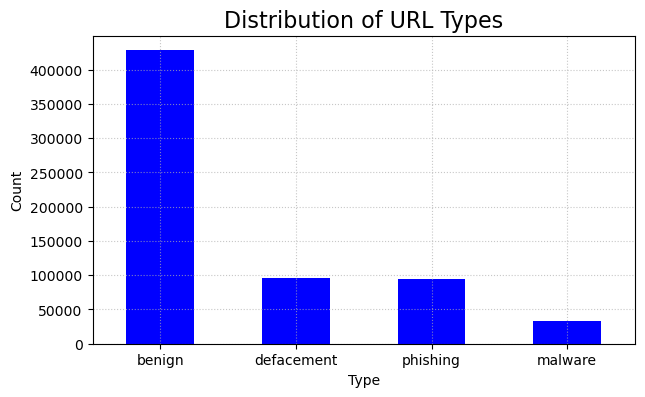

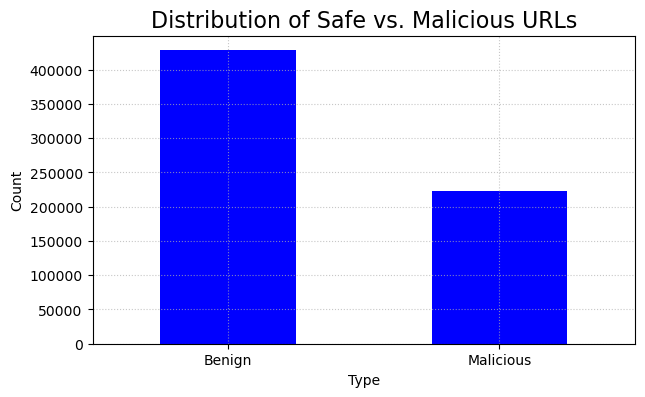

In [7]:
df['type'].value_counts().plot(kind='bar', figsize=(7, 4), color='blue')

# Add title and labels
plt.title('Distribution of URL Types', fontsize=16)
plt.xlabel('Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=0) # Keeps the x-axis labels horizontal
plt.show()

label_map = {0: 'Benign', 1: 'Malicious'}

df['malicious'].map(label_map).value_counts().plot(
    kind='bar', 
    figsize=(7, 4), 
    color='blue'
)

plt.title('Distribution of Safe vs. Malicious URLs', fontsize=16)
plt.xlabel('Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=0)
plt.show()


# Feature Engineering

#### Length Based Features 

In [8]:
# Length of URL
df['url_length'] = df['url'].str.len()
# df.head()

#### Count Based Features

In [9]:
# Number of digits
df['num_digits'] = df['url'].str.count(r'\d')

# Number of periods
df['num_periods'] = df['url'].str.count(r'\.')

# Number of slashes
df['num_slashes'] = df['url'].str.count(r'\/')

# Number of @ symbols
df['num_ats'] = df['url'].str.count(r'\@')
# df.head()

#### Binary Features

In [10]:
# Functions for advanced features

# Extract domain name (google.com, amazon.com, etc.)
def extract_domain(url):
    extracted = tldextract.extract(url)
    return extracted.domain

df['domain'] = df['url'].apply(extract_domain)


# List of brands
brands = ['google', 'paypal', 'microsoft', 'apple', 'amazon', 'netflix', 'facebook']

# Typosquat
def get_typosquat_feature(url_domain):
    min_dist = 100 

    clean_domain = url_domain.lower()
    
    for brand in brands:
        dist = Levenshtein.distance(clean_domain, brand)
        if dist < min_dist:
            min_dist = dist
            
    return min_dist

df['min_brand_dist'] = df['domain'].apply(get_typosquat_feature)

# Flag domains that are close to a brand name but not exact
def categorize_typosquat(dist):
    # if dist = 0 its the real brand
    if dist == 0:
        return 0 
    # flag if its close to the brand name but not exact (go0gle has dist 1)
    elif 0 < dist <= 2:
        return 1 
    # ignore if not close at all
    else:
        return 0 

df['is_typosquat'] = df['min_brand_dist'].apply(categorize_typosquat)

# ratio of digits to total length - high ratio is more suspicious
df['digit_len_ratio'] = df['num_digits'] / df['url_length']

# Suspicious brand word usage
def check_brand_usage(row):
    url_str = str(row['url']).lower()
    domain_str = str(row['domain']).lower()
    
    for brand in brands:
        # Check if brand name appears in the URL path/subdomain...
        if brand in url_str:
            # ...but is NOT the actual domain name (e.g. paypal-login.com)
            if brand not in domain_str:
                return 1 # Suspicious!
    return 0

df['is_suspicious_brand_usage'] = df.apply(check_brand_usage, axis=1)


,url,type,malicious,url_length,num_digits,num_periods,num_slashes,num_ats,domain,min_brand_dist,is_typosquat,digit_len_ratio
0,br-icloud.com.br,phishing,1,16,0,2,0,0,br-icloud,8,0,0.000000
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,1,2,2,0,mp3raid,6,0,0.028571
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,1,2,3,0,bopsecrets,8,0,0.032258
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,7,3,3,0,garage-pirenne,11,0,0.079545
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,22,2,3,0,adventure-nicaragua,16,0,0.093617


In [11]:
# Ensure URL column is string
df['url'] = df['url'].astype(str)

# Has ".htm" or ".html"
df['has_html'] = df['url'].str.contains(r'\.html?', case=False, na=False).astype(int)

# Has literal "?query="
df['has_query_param'] = df['url'].str.contains(r'\?query=', case=False, na=False).astype(int)

# Has "https://"
df['has_https'] = df['url'].str.contains(r'^https://', case=False, na=False).astype(int)

# Has "http://" (less secure)
df['has_http'] = df['url'].str.contains(r'^http://', case=False, na=False).astype(int)

# Has IPv4 address in the host part (after ://)
df['has_ip_address'] = df['url'].str.contains(r'://(?:\d{1,3}\.){3}\d{1,3}', case=False, na=False).astype(int)

# Suspicious keywords anywhere in URL
suspicious_kw = {'login', 'secure', 'payment', 'verify'}
pattern = '(' + '|'.join(suspicious_kw) + ')'
df['has_suspicious_kw'] = df['url'].str.contains(pattern, case=False, na=False).astype(int)

# Brand keywords
df['has_brand_kw'] = df['url'].str.contains(r'(google|paypal|microsoft)', case=False, na=False).astype(int)

# Has non ascii characters - mixed scripts
df['has_non_ascii_chars'] = df['url'].str.contains(r'[^\x00-\x7F]', regex=True).astype(int)

df.head(5)


/var/folders/z0/vb2s3c210wddnfxgxfh_yy080000gn/T/ipykernel_97185/1759717975.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_suspicious_kw'] = df['url'].str.contains(pattern, case=False, na=False).astype(int)
/var/folders/z0/vb2s3c210wddnfxgxfh_yy080000gn/T/ipykernel_97185/1759717975.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_brand_kw'] = df['url'].str.contains(r'(google|paypal|microsoft)', case=False, na=False).astype(int)


url        type  malicious  \
0                                   br-icloud.com.br    phishing          1   
1                mp3raid.com/music/krizz_kaliko.html      benign          0   
2                    bopsecrets.org/rexroth/cr/1.htm      benign          0   
3  http://www.garage-pirenne.be/index.php?option=...  defacement          1   
4  http://adventure-nicaragua.net/index.php?optio...  defacement          1   

   url_length  num_digits  num_periods  num_slashes  num_ats  \
0          16           0            2            0        0   
1          35           1            2            2        0   
2          31           1            2            3        0   
3          88           7            3            3        0   
4         235          22            2            3        0   

                domain  min_brand_dist  is_typosquat  digit_len_ratio  \
0            br-icloud               8             0         0.000000   
1              mp3raid               6             0         0.028571   
2           bopsecrets               8             0         0.032258   
3       garage-pirenne              11             0         0.079545   
4  adventure-nicaragua              16             0         0.093617   

   has_html  has_query_param  has_https  has_http  has_ip_address  \
0         0                0          0         0               0   
1         1                0          0         0               0   
2         1                0          0         0               0   
3         0                0          0         1               0   
4         0                0          0         1               0   

   has_suspicious_kw  has_brand_kw  has_non_ascii_chars  
0                  0             0                    0  
1                  0             0                    0  
2                  0             0                    0  
3                  0             0                    0  
4                  0             0                    0

# Model Training and Results

#### X, y setup

In [ ]:
# Setup X and y and scale X
y = df['malicious']
X = df.drop(['url', 'malicious', 'type', 'domain', 'users'], axis=1, errors='ignore')

# scaled X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Logistic Regression (K-fold)

In [13]:
log_reg = LogisticRegression(max_iter=1000)     #maximum number of iterations for optimization.

# create kf as a K-Fold cross validator and relevant indicies cv_split
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_split = kf.split(X_scaled)

# fit the logistic regression model log_reg to the split X and y training sets and make prediction
log_reg = LogisticRegression(max_iter=1000) 
log_reg.fit(X_scaled,y)
y_pred = cross_val_predict(log_reg, X_scaled, y, cv=cv_split)

# score evaluation
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

Confusion Matrix:
[[402883  25220]
 [ 75726 147362]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89    428103
           1       0.85      0.66      0.74    223088

    accuracy                           0.84    651191
   macro avg       0.85      0.80      0.82    651191
weighted avg       0.85      0.84      0.84    651191



#### Logistic Regression (Train-Test Split)

In [14]:
# split into 80/20 train to test split 
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size = .2, random_state = 42)

# fit the logistic regression model log_reg to the split X and y training sets and make prediction
log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_test)

# score evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[80669  5109]
 [15059 29402]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     85778
           1       0.85      0.66      0.74     44461

    accuracy                           0.85    130239
   macro avg       0.85      0.80      0.82    130239
weighted avg       0.85      0.85      0.84    130239



In [39]:
# functions for trees

# function to return F1, Accuracy, Precision, and Recall
# return: dict containing metrics
def metrics_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec  = tp / (tp + fn) if (tp + fn) else 0.0
    f1   = 2*prec*rec / (prec + rec) if (prec + rec) else 0.0
    acc  = (tp + tn) / cm.sum() if cm.sum() else 0.0
    return dict(precision=prec, recall=rec, f1=f1, accuracy=acc)

# function to get the best hyperparameter combo from a grid search and print the results
def print_best_results(results):
    # extract best f1 score combination and print 
    best = max(results, key=lambda r: r['f1'])

    if (best['model'] == 'LinearSVM'):
        svm_best_params = {'C': best['C']}
    else:
        svm_best_params = {'max depth': best['max_depth'], 
                           'criterion': best['criterion'], 
                           'min_samples_split': best['min_samples_split'],}

    svm_best_f1 = best['f1']
    svm_cm = best['cm']

    print("Best Hyperparameters:", svm_best_params)
    print("Best F1 Score:", round(svm_best_f1, 4))
    print("Confusion Matrix:\n", svm_cm, "\n")

#### Support Vector Machine (Train-Test)

In [ ]:
# need to make a smaller dataset since SVC creates an n x n array
X_small = X[:len(X)//10]
y_small = y[:len(y)//10]

# proceed as usual
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

results = []

for C in [0.1, 1, 10]:
    clf = SVC(C=C, kernel='linear')
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    mets = metrics_from_cm(cm)
    results.append({
        'model': 'LinearSVM', 
        'C': C, 
        'cm': cm, 
        **mets})

print_best_results(results=results)

#### SVM (K-Fold)

In [ ]:
# need to make a smaller dataset since SVC creates an n x n array
X_small = X[:len(X)//10]
y_small = y[:len(y)//10]

scaler = StandardScaler()
X_small_scaled = scaler.fit_transform(X_small)

# declare k-fold object 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for C in [0.1, 1, 10]:
    # Train model
    clf = SVC(C=C, kernel='linear')
    y_pred = cross_val_predict(clf, X_small_scaled, y_small, cv=kf)
    
    # Calculate metrics
    cm = confusion_matrix(y_small, y_pred, labels=[0, 1])
    mets = metrics_from_cm(cm)
    results.append({
        'model': 'LinearSVM', 
        'C': C, 
        'cm': cm, 
        **mets
    })

print_best_results(results=results)

Best SVM Parameters: {'C': 10}
Best SVM F1 Score: 0.8293
SVM Confusion Matrix:
 [[45655  2118]
 [ 3557 13789]] 



#### Decision Tree (Test-Train Split)

In [41]:
# set test and train data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42)

# scale test and train
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# tree hyperparameters
tree_params = {
    'max_depth': [3,5],
    'criterion': ['entropy'],
    'min_samples_split': [2, 5]
}

results = []

# Loop through all SVM parameters
for max_depth in tree_params['max_depth']:
    for criterion in tree_params['criterion']:
        for min_samples_split in tree_params['min_samples_split']:
            
            # create SVC object with given parameters
            clf = DecisionTreeClassifier(
                max_depth=max_depth,
                criterion=criterion,
                min_samples_split=min_samples_split
            )

            # fit object on training data and generate prediction
            clf.fit(X_train, y_train)
            yp = clf.predict(X_test)

            # add prediction to cm
            cm = confusion_matrix(y_test, yp, labels=[0, 1])
            mets = metrics_from_cm(cm)
            results.append({
                'model': 'Decision Tree', 'max_depth': max_depth, 'criterion': criterion, 'min_samples_split': min_samples_split,
                'cm': cm, **mets
            })

print_best_results(results=results)

Best Hyperparameters: {'max depth': 5, 'criterion': 'entropy', 'min_samples_split': 2}
Best F1 Score: 0.8353
Confusion Matrix:
 [[84749  1029]
 [11839 32622]] 



#### Decision Tree (K-Fold)

In [42]:
# tree hyperparameters
tree_params = {
    'max_depth': [3,5],
    'criterion': ['entropy'],
    'min_samples_split': [2, 5]
}

results = []

# create kf as a K-Fold cross validator and relevant indicies cv_split
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_split = kf.split(X_scaled)

# Loop through all SVM parameters
for max_depth in tree_params['max_depth']:
    for criterion in tree_params['criterion']:
        for min_samples_split in tree_params['min_samples_split']:

            clf = DecisionTreeClassifier(
                max_depth=max_depth,
                criterion=criterion,
                min_samples_split=min_samples_split
            )

            # cross_val_predict trains internally – no clf.fit() here
            y_pred = cross_val_predict(clf, X_scaled, y, cv=kf)

            # Compare to full y (not y_test)
            cm = confusion_matrix(y, y_pred, labels=[0, 1])
            mets = metrics_from_cm(cm)

            results.append({
                'model': 'Decision Tree', 'max_depth': max_depth, 'criterion': criterion, 'min_samples_split': min_samples_split,
                'cm': cm, **mets
            })
    
print_best_results(results)

Best Hyperparameters: {'max depth': 5, 'criterion': 'entropy', 'min_samples_split': 2}
Best F1 Score: 0.8351
Confusion Matrix:
 [[423129   4974]
 [ 59582 163506]] 



#### XGBoost (K-Fold)

In [43]:
# Hyperparameter grid
param_grid_xg = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# K-fold cross-validation 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_true_xg = []
y_pred_xg = []

for train_idx, test_idx in kf.split(X, y):
    # set training and test X and y
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Grid search on the training fold
    model = GridSearchCV(
        XGBClassifier(),
        param_grid_xg,
        scoring='f1',
        cv=3
    )
    
    model.fit(X_train, y_train)
    
    # use best estimator from grid search
    best_xgb = model.best_estimator_
    pred = best_xgb.predict(X_test)

    # collect predictions and true labels
    y_true_xg.extend(y_test.values)
    y_pred_xg.extend(pred)


Confusion Matrix:
[[413997  14106]
 [ 32802 190286]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    428103
           1       0.93      0.85      0.89    223088

    accuracy                           0.93    651191
   macro avg       0.93      0.91      0.92    651191
weighted avg       0.93      0.93      0.93    651191



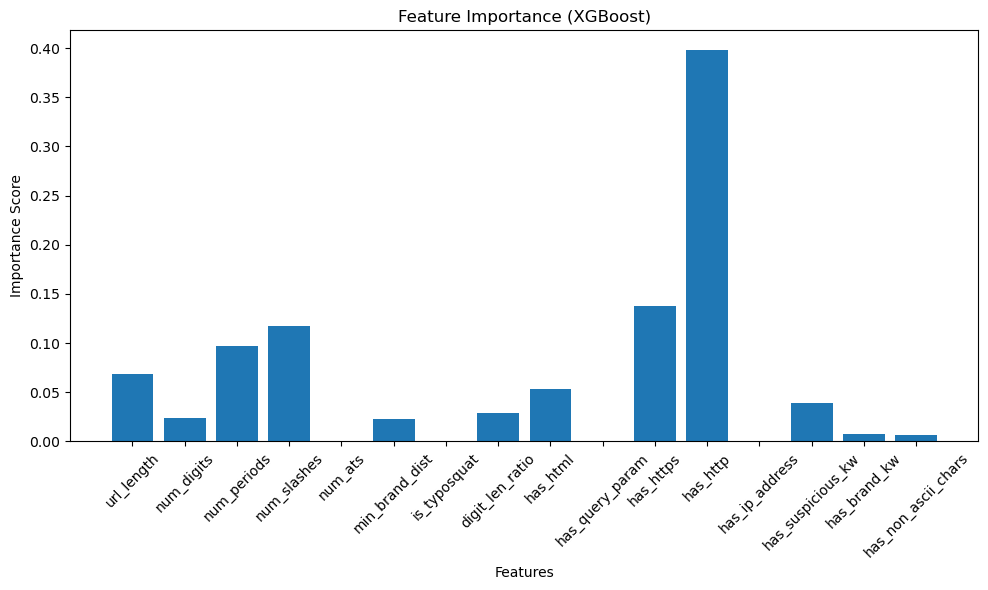

In [44]:
# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_true_xg, y_pred_xg))
print("Classification Report:")
print(classification_report(y_true_xg, y_pred_xg))

# Feature Importance
best_model = model.best_estimator_ #get hyperparameter combination for the best model.
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
plt.bar(features, importances)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Random Forest (K-Fold)

In [ ]:
# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]   
}

# K-fold cross-validation 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_true = []
y_pred = []

for train_idx, test_idx in kf.split(X, y):
    # set training and test X and y
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Grid search on the training fold
    model = GridSearchCV(RandomForestClassifier(),
                         param_grid, 
                         scoring='f1',  # Use F1 score for evaluation
                         cv=3)
    
     # fit model object on training data and make prediction
    model.fit(X_train, y_train)       
    pred = model.predict(X_test)

    # add predictiction and corresponding actual value to arrays
    y_true.extend(y_test.values)     
    y_pred.extend(pred)


Confusion Matrix:
[[420476   7627]
 [ 36482 186606]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95    428103
           1       0.96      0.84      0.89    223088

    accuracy                           0.93    651191
   macro avg       0.94      0.91      0.92    651191
weighted avg       0.93      0.93      0.93    651191



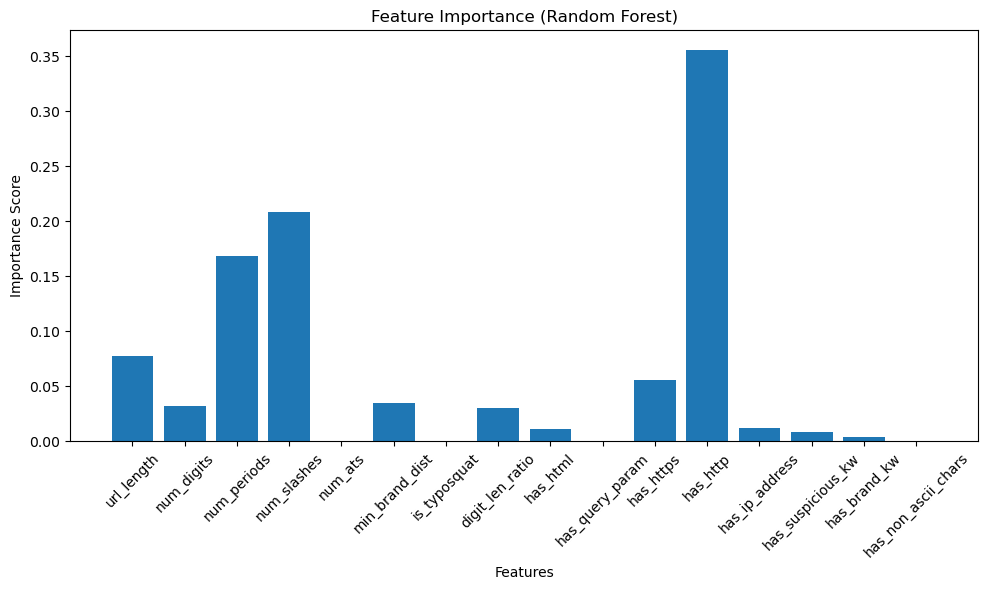

In [19]:
# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Feature Importance
best_model = model.best_estimator_
importances = best_model.feature_importances_
features = X.columns

# Plot histogram
plt.figure(figsize=(10,6))
plt.bar(features, importances)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Neural Network

In [23]:
# **** SAVED DATA AS CSV TO SPEED UP PROCESSING ****    
df = pd.read_csv('processed_data.csv')

##### Initialize Features - Numerical and Text

In [ ]:
# NUMERICAL FEATURES
# Calculate Shannon entropy - measures how random the url is (if its gibberish its probably bad)
def calc_entropy(text):
    if not text: return 0
    entropy = 0
    for x, n in Counter(str(text)).items():
        p = n / len(text)
        entropy -= p * math.log2(p)
    return entropy

df['entropy'] = df['url'].apply(calc_entropy)

# Extract TLD 
df['tld'] = df['url'].apply(lambda x: x.split('.')[-1].split('/')[0])
top_tlds = df['tld'].value_counts().nlargest(20).index
df['tld_processed'] = df['tld'].apply(lambda x: x if x in top_tlds else 'other')
tld_dummies = pd.get_dummies(df['tld_processed'], prefix='tld')

# Drop non-numerical columns
drop_cols = ['url', 'type', 'malicious', 'domain', 'users', 'min_brand_dist', 'is_typosquat', 'tld', 'tld_processed']
numeric_cols = [c for c in df.columns if c not in drop_cols]
X_num_raw = df[numeric_cols]

# Join TLD features to numerical features
X_num_raw = pd.concat([X_num_raw, tld_dummies], axis=1)

# Scale numerical data
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num_raw)

# TEXT FEATURES 

# Character-level Tokenization 
# Instead of each word being a token we treat the URL as a sequence of characters
tokenizer = Tokenizer(char_level=True, oov_token='UNK')
tokenizer.fit_on_texts(df['url'])
sequences = tokenizer.texts_to_sequences(df['url'])

# Pad sequences
max_len = 200 
X_text = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# LABELS AND SPLIT

y_raw = df['type']
encoder = LabelEncoder()
y_int = encoder.fit_transform(y_raw)
y_categorical = to_categorical(y_int)
num_classes = y_categorical.shape[1]

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_int),
    y=y_int
)
weights_dict = dict(enumerate(class_weights))

# Split data
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y_categorical, test_size=0.2, random_state=42)
X_num_train, X_num_test, _, _ = train_test_split(X_num, y_categorical, test_size=0.2, random_state=42)

Text Input Shape: (520952, 200)
Numeric Input Shape: (520952, 37)


##### Build and Train Model

In [ ]:
def build_hybrid_model():
    # Part 1 - numerical data
    input_num = Input(shape=(X_num_train.shape[1],), name='numeric_input')
    x1 = layers.Dense(64, activation='relu')(input_num)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.3)(x1)

    # Part 2 - Character embedding + CNN
    input_text = Input(shape=(max_len,), name='text_input')
    
    vocab_size = len(tokenizer.word_index) + 1
    
    # Embedding layer
    x2 = layers.Embedding(input_dim=vocab_size, output_dim=32, input_length=max_len)(input_text)
    
    # Conv1D layers
    x2 = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(x2)
    x2 = layers.MaxPooling1D(pool_size=2)(x2)
    
    x2 = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(x2)
    x2 = layers.GlobalMaxPooling1D()(x2)
    x2 = layers.Dropout(0.3)(x2)

    # Merge numeric and text features
    merged = concatenate([x1, x2])
    
    x = layers.Dense(128, activation='relu')(merged)
    x = layers.Dropout(0.3)(x)
    
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[input_text, input_num], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("\nTraining Neural Network")
model = build_hybrid_model()

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,       
    patience=2,       
    min_lr=0.00001,   
    verbose=1
)

history = model.fit(
    [X_text_train, X_num_train], 
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32, 
    callbacks=[early_stop, lr_scheduler], 
    class_weight=weights_dict,
    verbose=1
)

loss, accuracy = model.evaluate([X_text_test, X_num_test], y_test, verbose=0)
print(f"Final Accuracy: {accuracy:.4f}")


Training Hybrid Model...


/Users/williamgephart/miniforge3/envs/ml_project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
13024/13024 ━━━━━━━━━━━━━━━━━━━━ 327s 25ms/step - accuracy: 0.8674 - loss: 0.4682 - val_accuracy: 0.9094 - val_loss: 0.3795 - learning_rate: 0.0010
Epoch 2/50
13024/13024 ━━━━━━━━━━━━━━━━━━━━ 364s 28ms/step - accuracy: 0.8647 - loss: 1.5663 - val_accuracy: 0.9370 - val_loss: 0.8385 - learning_rate: 0.0010
Epoch 3/50
13024/13024 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8625 - loss: 4.0911
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13024/13024 ━━━━━━━━━━━━━━━━━━━━ 1109s 85ms/step - accuracy: 0.8621 - loss: 5.6567 - val_accuracy: 0.8935 - val_loss: 8.0791 - learning_rate: 0.0010
Epoch 4/50
13024/13024 ━━━━━━━━━━━━━━━━━━━━ 311s 24ms/step - accuracy: 0.8643 - loss: 5.5741 - val_accuracy: 0.9272 - val_loss: 5.1139 - learning_rate: 5.0000e-04
Epoch 5/50
13024/13024 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8650 - loss: 7.1822
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
13024/13024 ━━━━━━━━━━━━━━━━━━━━ 327

##### Visualize Results

4070/4070 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
              precision    recall  f1-score   support

      benign       0.99      0.90      0.94     85778
  defacement       0.98      0.96      0.97     19104
     malware       0.79      0.92      0.85      6521
    phishing       0.65      0.87      0.74     18836

    accuracy                           0.91    130239
   macro avg       0.85      0.91      0.88    130239
weighted avg       0.93      0.91      0.91    130239



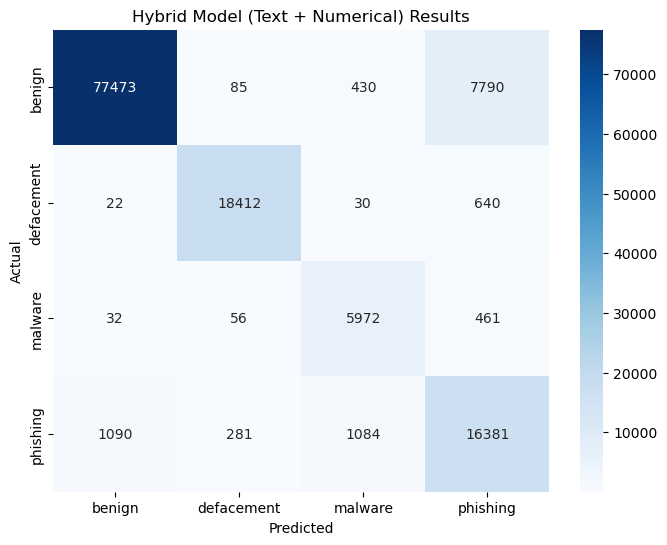

In [26]:
y_pred_probs = model.predict([X_text_test, X_num_test])
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_)
plt.title('Hybrid Model (Text + Numerical) Results')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()